### Useful links:
- https://habr.com/ru/articles/779526/
- https://aws.amazon.com/what-is/retrieval-augmented-generation/
- https://www.databricks.com/glossary/retrieval-augmented-generation-rag

### Code example in this notebook:
- https://medium.com/@jiangan0808/retrieval-augmented-generation-rag-with-open-source-hugging-face-llms-using-langchain-bd618371be9d

### What is RAG and how does it work?

**Retrieval** - поиск и извлечение релевантной информации. Часть системы, которая отвечает за поиск и извлечение информации, так и называют — ретривер (retriever).

**Retrieval Augmented** — дополнение запроса пользователя найденной релевантной информацией.

**Retrieval Augmented Generation** — генерация ответа пользователю с учетом дополнительно найденной релевантной информации.

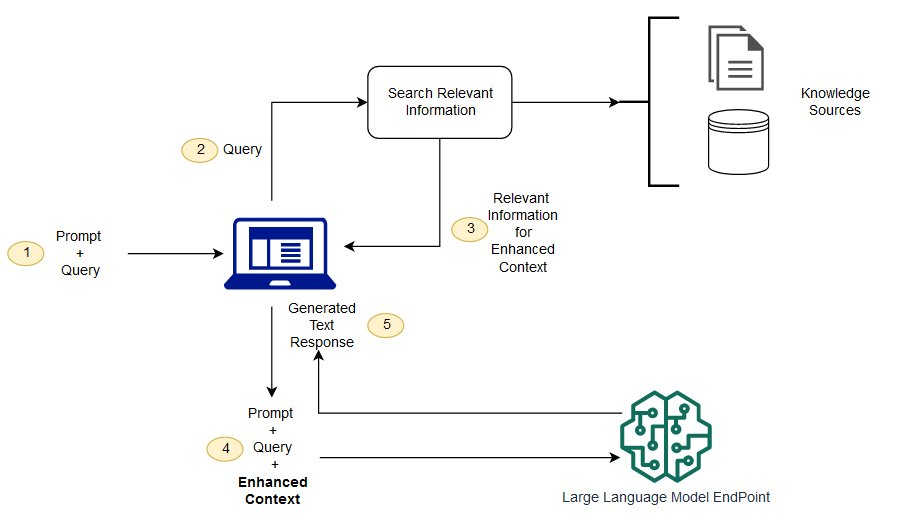

### Prompt engineering vs. RAG vs. Fine-tune vs. Pre-train

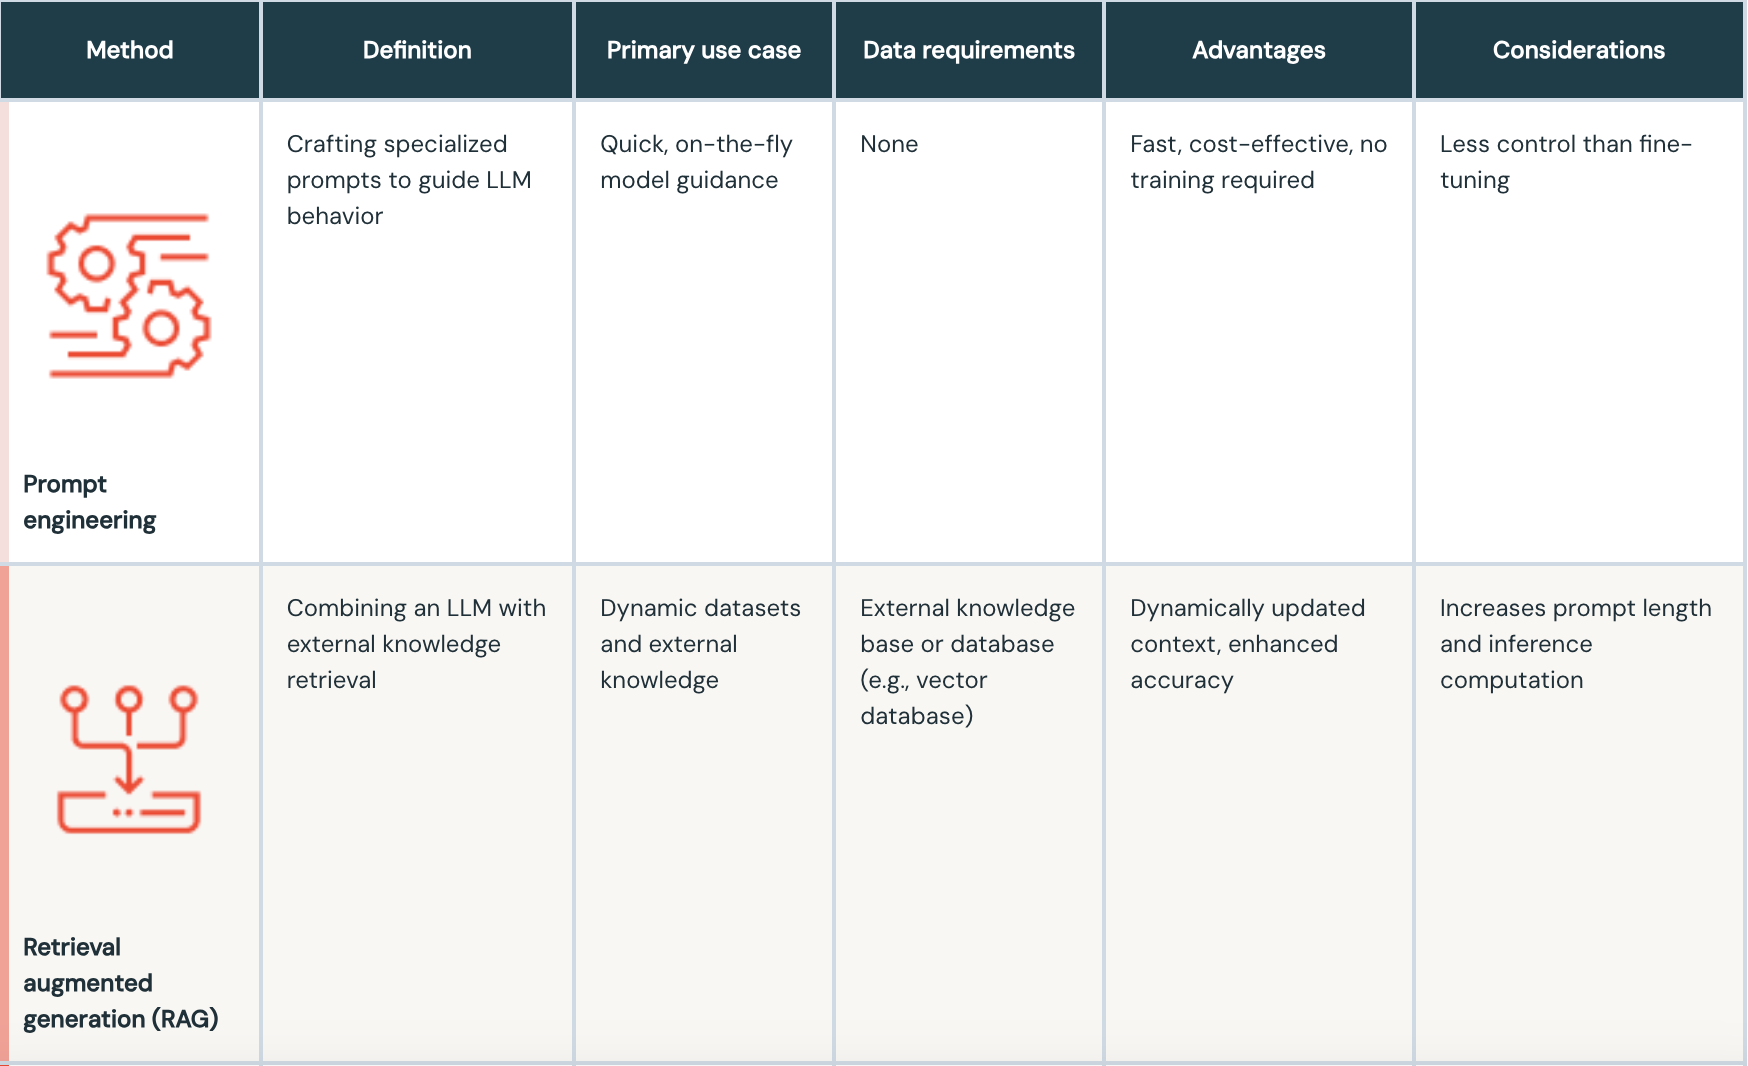
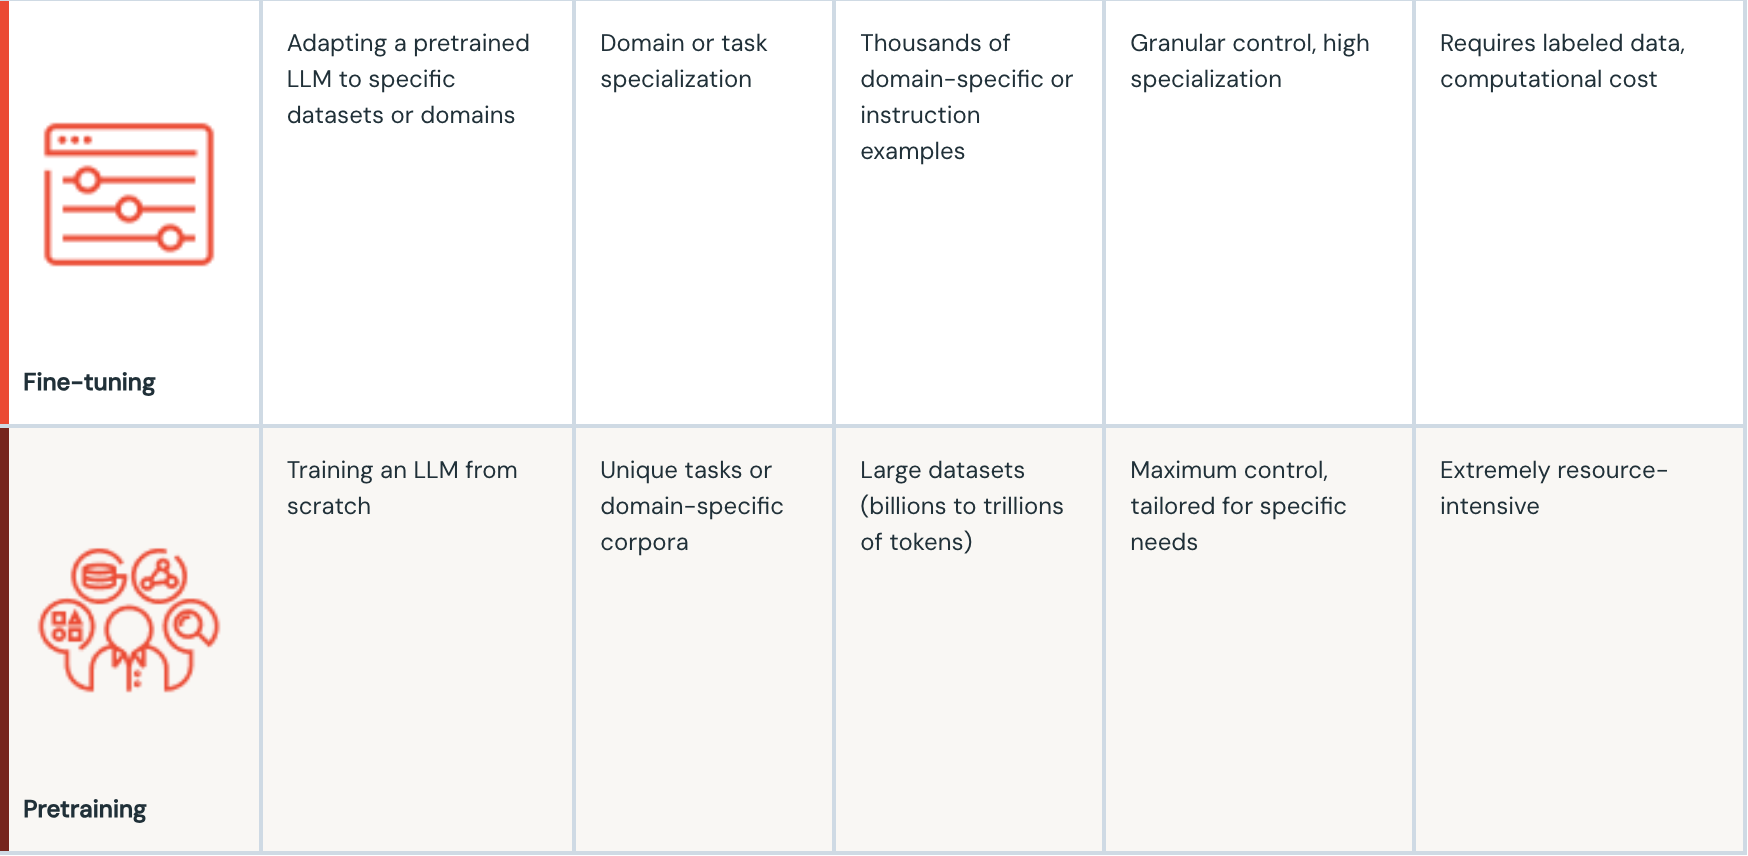

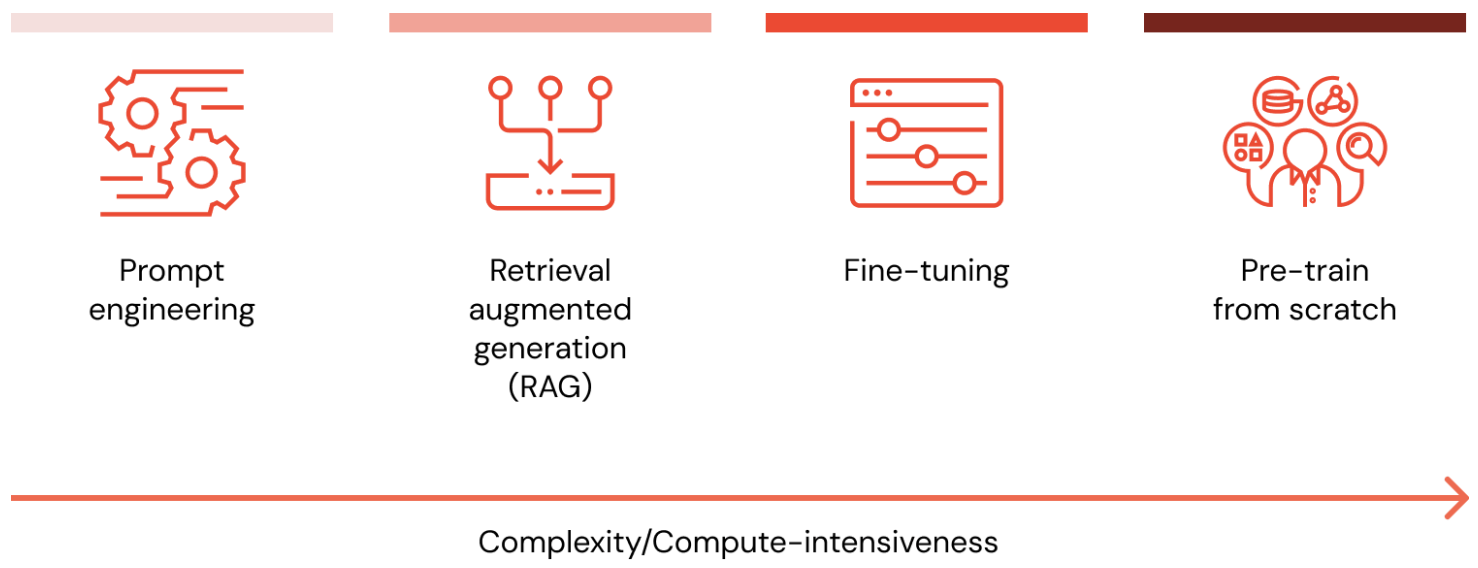

### Try it yourself!

#### 1. Подготовка среды

In [71]:
# !pip install -U transformers langchain torch faiss-cpu numpy pypdf dotenv
# !pip install -U sentence-transformers

In [60]:
import dotenv

dotenv.load_dotenv(".env", override=True)

True

In [58]:
import numpy as np
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.llms import HuggingFacePipeline, HuggingFaceHub
from langchain_community.vectorstores import FAISS

#### 2. Загрузка документов-источников и превращение в эмбеддинги

In [40]:
FOLDER_NAME = "drg"

In [50]:
# Load pdf files in the local directory
loader = PyPDFDirectoryLoader(f"./{FOLDER_NAME}/")

docs_before_split = loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 700,
    chunk_overlap = 50,
)
docs_after_split = text_splitter.split_documents(docs_before_split)

docs_after_split[0]

Document(metadata={'source': 'drg/DRG Rule Book.pdf', 'page': 0}, page_content='RULEBOOK')

In [51]:
avg_doc_length = lambda docs: sum([len(doc.page_content) for doc in docs])//len(docs)
avg_char_before_split = avg_doc_length(docs_before_split)
avg_char_after_split = avg_doc_length(docs_after_split)

print(f"Before split, there were {len(docs_before_split)} documents loaded, with average characters equal to {avg_char_before_split}.")
print(f"After split, there were {len(docs_after_split)} documents (chunks), with average characters equal to {avg_char_after_split} (average chunk length).")

Before split, there were 25 documents loaded, with average characters equal to 2521.
After split, there were 108 documents (chunks), with average characters equal to 588 (average chunk length).


In [52]:
huggingface_embeddings = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-small-en-v1.5",  # alternatively use "sentence-transformers/all-MiniLM-l6-v2" for a light and faster experience.
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},
)

In [53]:
sample_embedding = np.array(huggingface_embeddings.embed_query(docs_after_split[0].page_content))
# print("Sample embedding of a document chunk: ", sample_embedding)
print("Size of the embedding: ", sample_embedding.shape)

Size of the embedding:  (384,)


#### 3. Инициализация ретривера

In [54]:
vectorstore = FAISS.from_documents(docs_after_split, huggingface_embeddings)

In [56]:
query_weapons = """What weapons are available for the engineer?"""
relevant_documents = vectorstore.similarity_search(query_weapons)
print(f"There are {len(relevant_documents)} documents retrieved which are relevant to the query. Display the first one:\n")
print(relevant_documents[0].page_content)

There are 4 documents retrieved which are relevant to the query. Display the first one:

using 
  Credits  and crafting resources . There are currently four unlockable weapons
per class. Each weapon has its own assignment . Once an assignment for a weapon
has been completed it can then be purchased from the upgrade terminal.
/0:02 38:29
Primary
"Warthog" Auto 210
Shotgun"Stubby" Voltaic SMG
Submachine GunLOK-1 Smart R
Submachine G
Secondary
Deepcore 40mm PGL
Heavy WeaponBreach Cutter
Heavy WeaponShard Diﬀrac
Heavy Weap
Equipment
Kursite Crystalarium
Support ToolLMG Gun Platform
Sentry Gun"Owl" Armor 
Armor Unders


Поисх по похожести отработал норм, выдал самое релевантное перечисление видов оружия для инженера

In [57]:
# Use similarity searching algorithm and return 3 most relevant documents.
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

#### 4. Работа online (LLM без RAG)


Модель: https://huggingface.co/mistralai/Mistral-7B-v0.1 

Currently, HuggingFace LangChain integration doesn’t support the question-answering task, so we can’t select HuggingFace QA models for this project

In [78]:
hf_hub = HuggingFaceHub(
    repo_id="mistralai/Mistral-7B-v0.1",
    model_kwargs={"temperature": 0.1, "max_length": 500},
)

query_objectives = """What kind of objectives in DRG missions are available?"""
hf_hub.invoke(query_objectives)

'What kind of objectives in DRG missions are available?\n\nThere are 3 types of objectives in DRG missions:\n\n- Collecting resources\n- Destroying enemy structures\n- Defending your base\n\nHow do I know what kind of objective I have?\n\nYou can see the objective type in the mission briefing.\n\nHow do I know what I have to do?\n\nYou can see the objective in the mission briefing.\n\nHow do I know how much time I have to complete the objective'

- 'What kind of objectives in DRG missions are available?
- There are 3 types of objectives in DRG missions:
    - Collecting resources
    - Destroying enemy structures
    - Defending your base
- How do I know what kind of objective I have?
- You can see the objective type in the mission briefing.
- How do I know what I have to do?
- You can see the objective in the mission briefing.
- How do I know how much time I have to complete the objective'


На текущем запуске звучит вообще не правдоподобно

При повторе запросов, в том числе через [интерфейс HF](https://huggingface.co/mistralai/Mistral-7B-v0.1), можно получить даже более-менее правдивую инфу, хотя все равно половину придумывает:

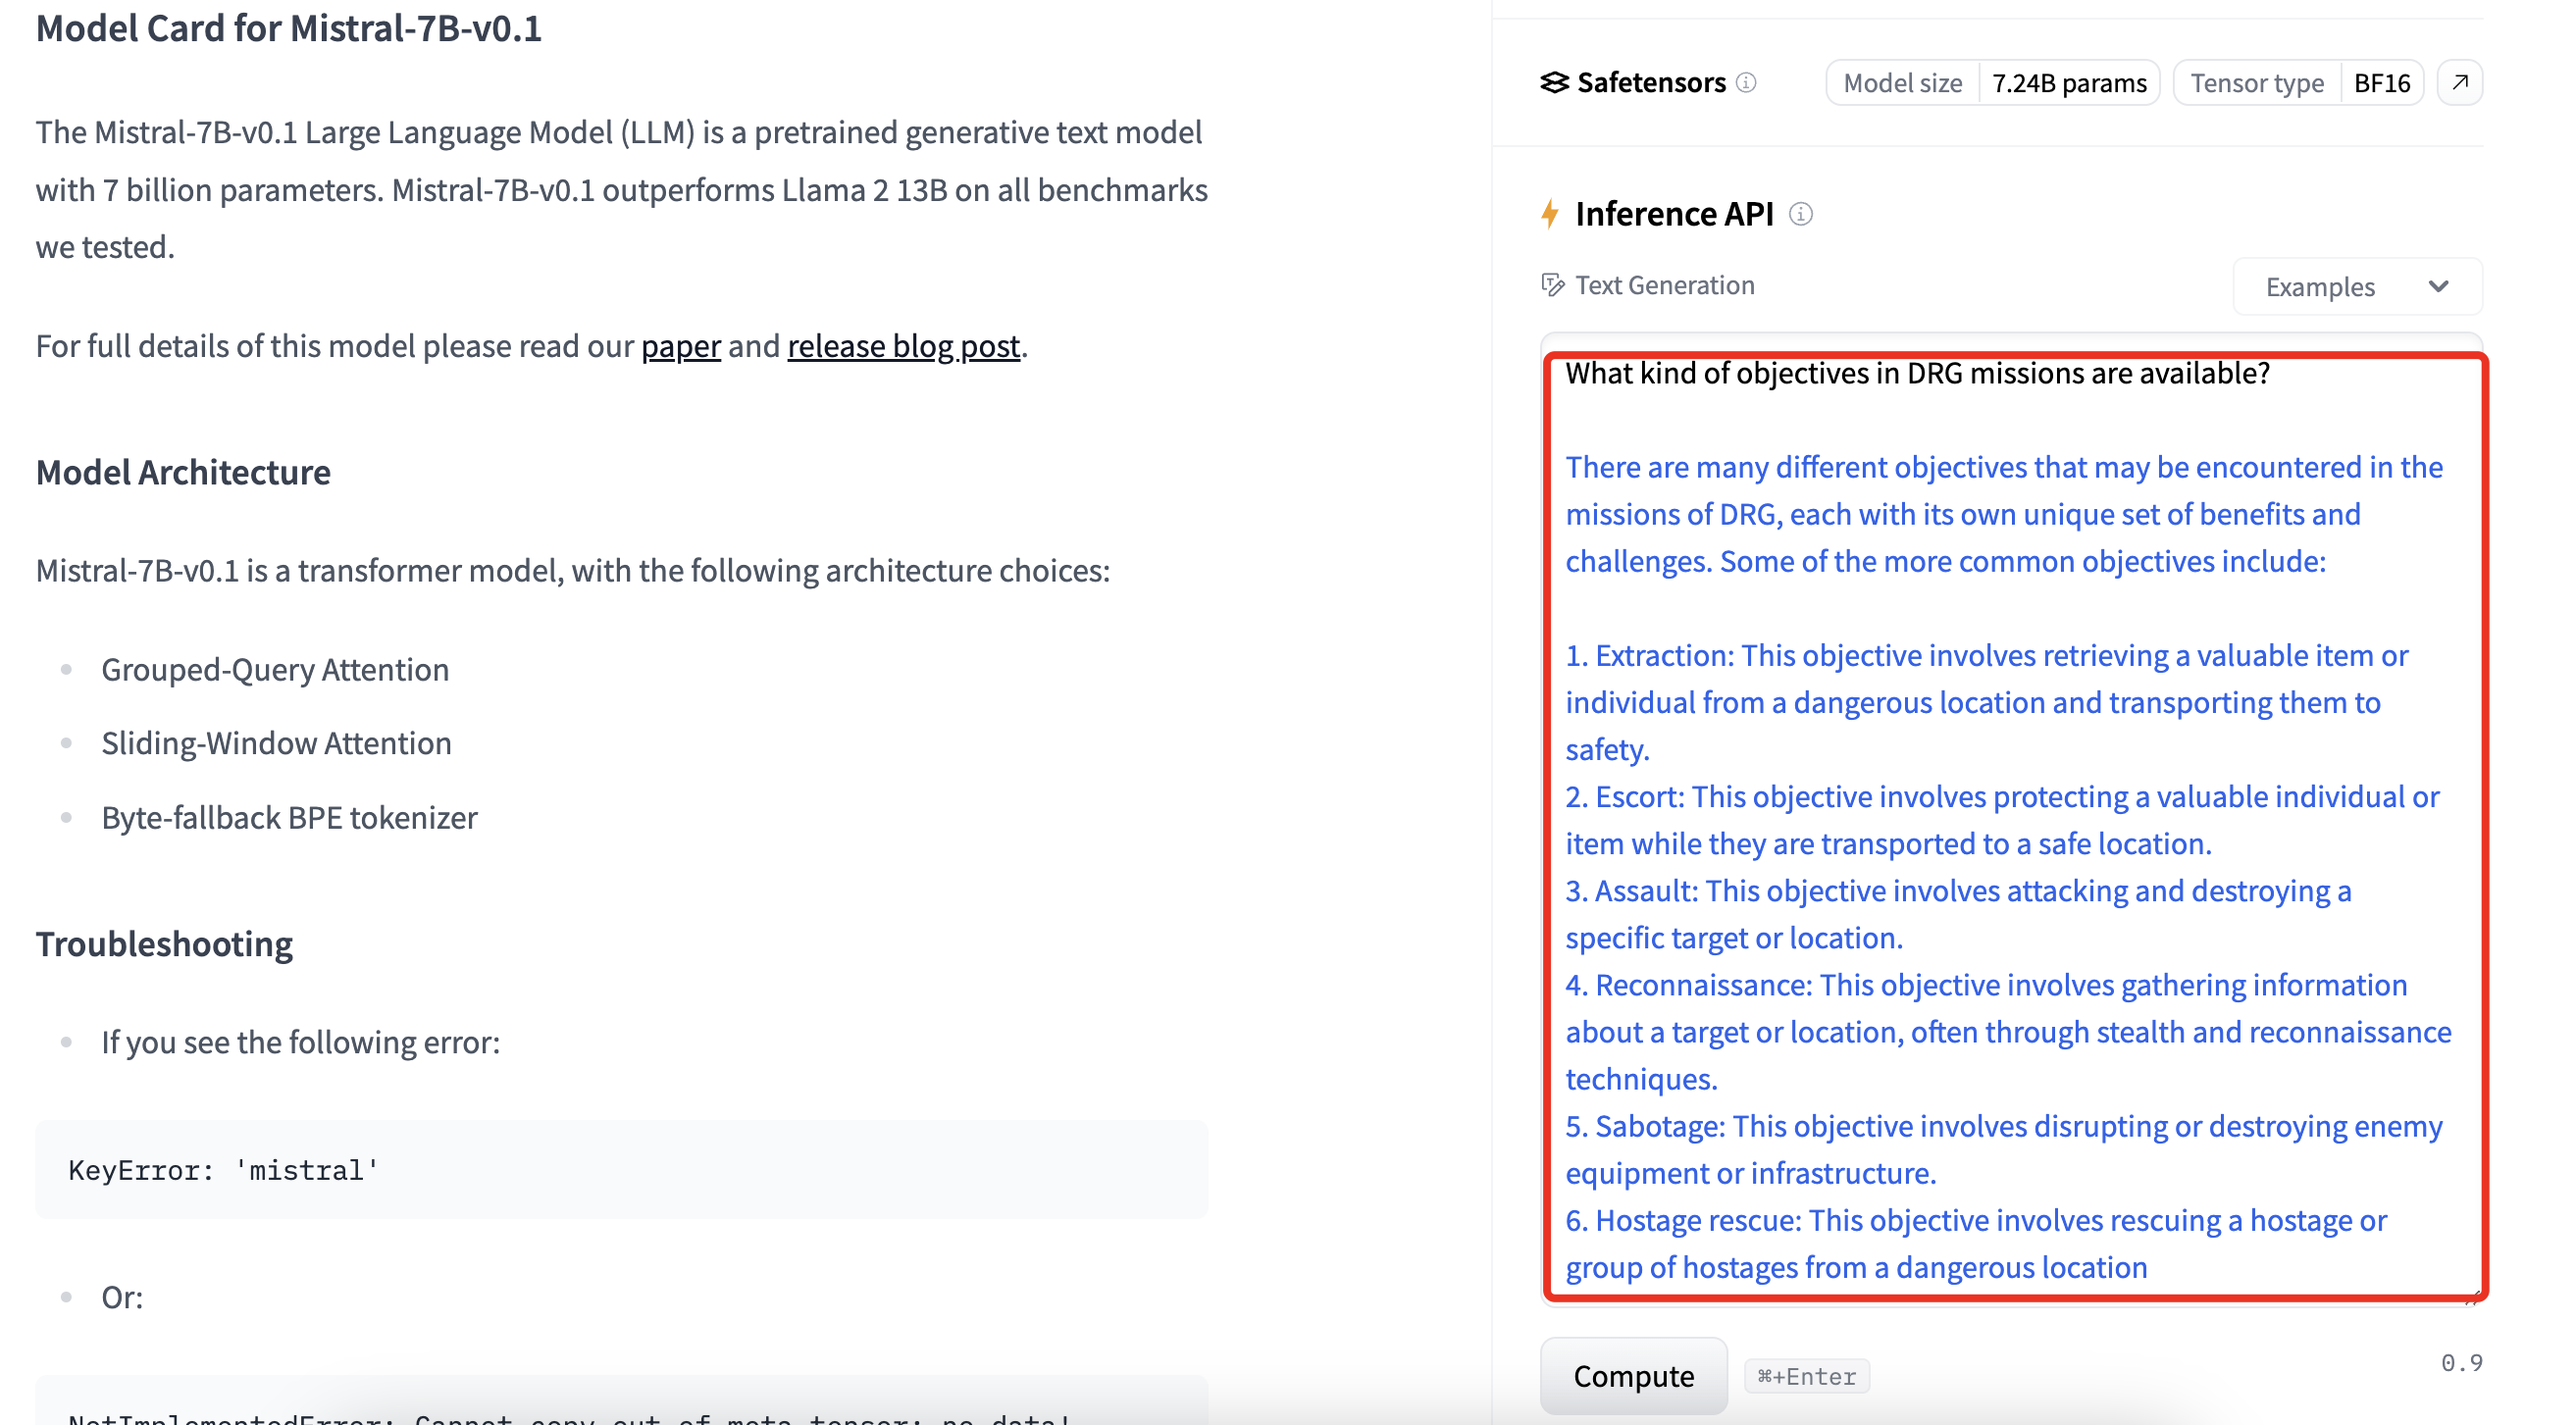

Ради кека спросим вот что:

In [ ]:
query_best = """Who is the best: engineer from deep rock galactic or engineer from tf2?"""
hf_hub.invoke(query_best)

'Who is the best: engineer from deep rock galactic or engineer from tf2?\n\nEngineer from deep rock galactic is better than engineer from tf2.\n\nEngineer from deep rock galactic is better than engineer from tf2.\n\nEngineer from deep rock galactic is better than engineer from tf2.\n\nEngineer from deep rock galactic is better than engineer from tf2.\n\nEngineer from deep rock galactic is better than engineer from tf2.\n\nEngineer from deep rock galactic is better than engineer from tf'

- 'Who is the best: engineer from deep rock galactic or engineer from tf2?

- Engineer from deep rock galactic is better than engineer from tf2.
- Engineer from deep rock galactic is better than engineer from tf2.
- Engineer from deep rock galactic is better than engineer from tf2.
- Engineer from deep rock galactic is better than engineer from tf2.
- Engineer from deep rock galactic is better than engineer from tf2.
- Engineer from deep rock galactic is better than engineer from tf'

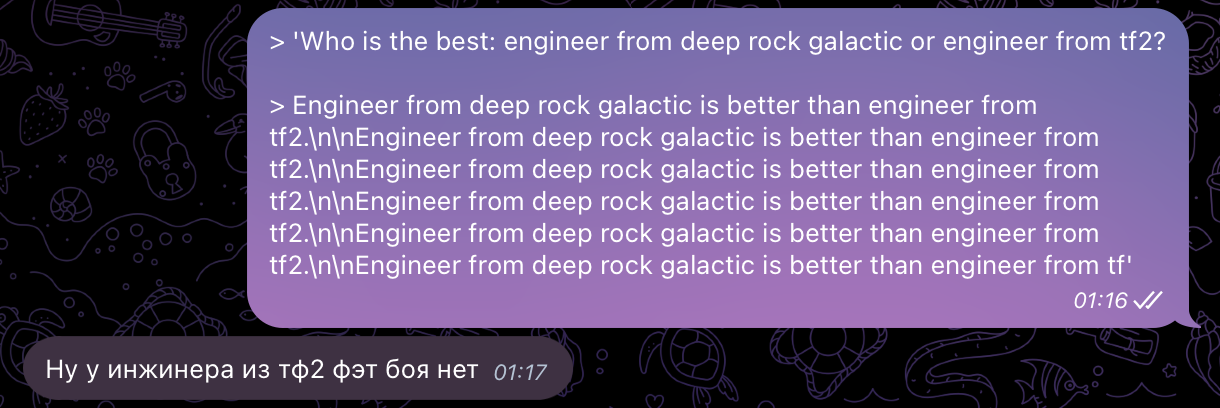

#### 5. Работа offline, чтобы потестить ретривер

Забыла поменять query 🤡

In [65]:
hf_pipe = HuggingFacePipeline.from_model_id(
    model_id="mistralai/Mistral-7B-v0.1",
    task="text-generation",
    pipeline_kwargs={"temperature": 0, "max_new_tokens": 300}
)

llm = hf_pipe
llm.invoke(query_best)

# 238 mins // on mac M2 pro 32GB

Loading checkpoint shards: 100%|██████████| 2/2 [00:44<00:00, 22.06s/it]
/Users/kristinakorotkova_1_2_3/PycharmProjects/slacktime/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


"Who is the best: engineer from deep rock galactic or engineer from tf2?\nUser 1: I'm not sure if you're joking or not, but I'll answer anyway.\n\nDeep Rock Galactic is a game where you play as a dwarf miner, and you have to mine for minerals and fight off monsters. The engineer is a class that can build turrets and other things to help you fight off the monsters.\n\nTeam Fortress 2 is a game where you play as a soldier, and you have to fight off the other team. The engineer is a class that can build turrets and other things to help you fight off the other team.\n\nSo, in my opinion, the engineer from Deep Rock Galactic is better than the engineer from Team Fortress 2.\nUser 0: I'm not joking, I'm just curious.\nUser 1: Oh, okay. Well, in my opinion, the engineer from Deep Rock Galactic is better than the engineer from Team Fortress 2.\nUser 0: I'm not sure if you're joking or not, but I'll answer anyway.\n\nDeep Rock Galactic is a game where you play as a dwarf miner, and you have to 

- "Who is the best: engineer from deep rock galactic or engineer from tf2?
- User 1: I'm not sure if you're joking or not, but I'll answer anyway.
- Deep Rock Galactic is a game where you play as a dwarf miner, and you have to mine for minerals and fight off monsters. The engineer is a class that can build turrets and other things to help you fight off the monsters.
- Team Fortress 2 is a game where you play as a soldier, and you have to fight off the other team. The engineer is a class that can build turrets and other things to help you fight off the other team.
- So, in my opinion, the engineer from Deep Rock Galactic is better than the engineer from Team Fortress 2.
- User 0: I'm not joking, I'm just curious.
- User 1: Oh, okay. Well, in my opinion, the engineer from Deep Rock Galactic is better than the engineer from Team Fortress 2.
- User 0: I'm not sure if you're joking or not, but I'll answer anyway.
- Deep Rock Galactic is a game where you play as a dwarf miner, and you have to mine for minerals and fight off monsters. The engineer is a class that can build turrets and other things to help you fight off the monsters.
- Team Fortress 2 is a game where you"


In [72]:
llm.invoke(query_objectives)

# 233 mins // on mac M2 pro 32GB

/Users/kristinakorotkova_1_2_3/PycharmProjects/slacktime/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


'What kind of objectives in DRG missions are available?\n\nThere are 3 types of objectives in DRG missions:\n\n- Collect a certain amount of resources\n- Defend a certain area\n- Destroy a certain amount of enemies\n\n## What are the different types of DRG missions?\n\nThere are 3 types of DRG missions:\n\n- Resource missions: These missions require you to collect a certain amount of resources.\n- Defense missions: These missions require you to defend a certain area.\n- Attack missions: These missions require you to destroy a certain amount of enemies.\n\n## What are the different types of DRG resources?\n\nThere are 3 types of DRG resources:\n\n- Ore: This is the most common type of resource. It is used to craft weapons and armor.\n- Crystals: These are used to craft special items.\n- Gems: These are used to craft powerful weapons and armor.\n\n## What are the different types of DRG weapons?\n\nThere are 3 types of DRG weapons:\n\n- Melee weapons: These are used to attack enemies up c

- 'What kind of objectives in DRG missions are available?
- There are 3 types of objectives in DRG missions:
    - Collect a certain amount of resources
    - Defend a certain area
    - Destroy a certain amount of enemies
    
- What are the different types of DRG missions?
- There are 3 types of DRG missions:
    - Resource missions: These missions require you to collect a certain amount of resources.
    - Defense missions: These missions require you to defend a certain area.
    - Attack missions: These missions require you to destroy a certain amount of enemies.

- What are the different types of DRG resources?
- There are 3 types of DRG resources:
    - Ore: This is the most common type of resource. It is used to craft weapons and armor.
    - Crystals: These are used to craft special items.
    - Gems: These are used to craft powerful weapons and armor.
    
- What are the different types of DRG weapons?
- There are 3 types of DRG weapons:
    - Melee weapons: These are used to attack enemies up close.
    - Ranged weapons: These are used to attack enemies from a distance.
    - Special weapons: These are used to attack enemies in a specific way.

- What are the different types of DRG armor?
- There are 3 types of DRG armor:
    - Light armor: This is'

Вроде бы в начале было по делу, но в целом без конкретики и половину придумал

In [66]:
prompt_template = """Use the following pieces of context to answer the question at the end. Please follow the following rules:
1. If you don't know the answer, don't try to make up an answer. Just say "I can't find the final answer but you may want to check the following links".
2. If you find the answer, write the answer in a concise way with five sentences maximum.

{context}

Question: {question}

Helpful Answer:
"""

PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

In [68]:
retrievalQA = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)

In [69]:
# Call the QA chain with our query.
result = retrievalQA.invoke({"query": query_objectives})
print(result["result"])

# 233 mins // on mac M2 pro 32GB

/Users/kristinakorotkova_1_2_3/PycharmProjects/slacktime/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Use the following pieces of context to answer the question at the end. Please follow the following rules:
1. If you don't know the answer, don't try to make up an answer. Just say "I can't find the final answer but you may want to check the following links".
2. If you find the answer, write the answer in a concise way with five sentences maximum.

Engineer, or Ziplines for the Gunner.
• Keep what Ammo, Health, Throwables, Rock & Stone cards and secondary 
weapon Overclocks you currently have.
• Keep up to one Weapon Upgrade. Any excess ones must be discarded to the 
shared stash, but you will be compensated with one extra Throwable per 
discarded upgrade.
• Remove all collected Minerals and pickups, as the content of the M.U.L.E. is 
shipped back to the Company.
• Each successful mission grants a free Rock & Stone card to each Dwarf that 
made it back into the Drop Pod.
• If you fail any mission, you can replay the current mission, using the normal 
setup rules (but then you lose any g

Мне понравилось, что в ответе появилось вполне конкретное слово "minerals", похоже на то, что взял его из первого источника.

Забавно, что зацикливаться начало, хотя даже в зацикливаниях просматривается использование терминов из источников ("secondary weapon")

In [70]:
relevant_docs = result["source_documents"]
print(f"There are {len(relevant_docs)} documents retrieved which are relevant to the query.")
print("*" * 100)
for i, doc in enumerate(relevant_docs):
    print(f"Relevant Document #{i + 1}:\nSource file: {doc.metadata['source']}, Page: {doc.metadata['page']}\nContent: {doc.page_content}")
    print("-" * 100)
    print(f"There are {len(relevant_docs)} documents retrieved which are relevant to the query.")

There are 3 documents retrieved which are relevant to the query.
****************************************************************************************************
Relevant Document #1:
Source file: drg/DRG Rule Book.pdf, Page: 18
Content: Engineer, or Ziplines for the Gunner.
• Keep what Ammo, Health, Throwables, Rock & Stone cards and secondary 
weapon Overclocks you currently have.
• Keep up to one Weapon Upgrade. Any excess ones must be discarded to the 
shared stash, but you will be compensated with one extra Throwable per 
discarded upgrade.
• Remove all collected Minerals and pickups, as the content of the M.U.L.E. is 
shipped back to the Company.
• Each successful mission grants a free Rock & Stone card to each Dwarf that 
made it back into the Drop Pod.
• If you fail any mission, you can replay the current mission, using the normal 
setup rules (but then you lose any gained upgrades, etc. from earlier missions.
----------------------------------------------------------------

Пробую чутка другой промт, чтобы ответ был покороче.

Алсо поняла, что в моих источниках собственно и не было *конкретной* инфы о целях миссий в DRG, так что меняем и query

Надеюсь получить конкретный ответ со страницы 7 в DRG Rule Book

In [80]:
another_prompt_template = """
"Use the given context to answer the question. "
"If you don't know the answer, say you don't know. "
"Use three sentence maximum and keep the answer concise. "

"Context: {context}"

Question: {question}

Helpful Answer:
"""

ANOTHER_PROMPT = PromptTemplate(template=another_prompt_template, input_variables=["context", "question"])

query_egg = """How can I collect an Alien Egg in Deep Rock Galactic?"""

In [74]:
retriever_w2_docs = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 2})

retrievalQA_with_another_promt_template = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever_w2_docs,
    return_source_documents=True,
    chain_type_kwargs={"prompt": ANOTHER_PROMPT}
)

result = retrievalQA_with_another_promt_template.invoke({"query": query_egg})
print(result["result"])

# 232 mins // on mac M2 pro 32GB

/Users/kristinakorotkova_1_2_3/PycharmProjects/slacktime/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



"Use the given context to answer the question. "
"If you don't know the answer, say you don't know. "
"Use three sentence maximum and keep the answer concise. "

"Context: always give at least one Gold. Then discard the Loot Bug.
Barley Bulb. Used to brew all kinds of tasty beverages back at the Abyss 
Bar. Collecting a Barley bulb increases morale as the Dwarves look forward 
to getting home and starting up the stills. Discard the Bulb as it is collected 
and draw a Rock and Stone card for yourself.
Apoca Bloom. White, faintly glowing petaled flowers, valuable to the 
company. Appears as a secondary objective in some missions. Add it to the 
shared pile when picked up.
Alien Egg. These large olive-green ovoid eggs are highly sought after and 
thus appear as an objective in some missions. A successful axe chop will

• Attack a creature on an adjacent space
• Carve out a passage by removing a wall adjacent to your space
• Destroy a Stalagmite adjacent to your space
Minerals collected a

In [76]:
relevant_docs = result["source_documents"]
print(f"There are {len(relevant_docs)} documents retrieved which are relevant to the query.")
print("*" * 100)
for i, doc in enumerate(relevant_docs):
    print(f"Relevant Document #{i + 1}:\nSource file: {doc.metadata['source']}, Page: {doc.metadata['page']}\nContent: {doc.page_content}")
    print("-" * 100)
    print(f"There are {len(relevant_docs)} documents retrieved which are relevant to the query.")

There are 2 documents retrieved which are relevant to the query.
****************************************************************************************************
Relevant Document #1:
Source file: drg/DRG Rule Book.pdf, Page: 6
Content: always give at least one Gold. Then discard the Loot Bug.
Barley Bulb. Used to brew all kinds of tasty beverages back at the Abyss 
Bar. Collecting a Barley bulb increases morale as the Dwarves look forward 
to getting home and starting up the stills. Discard the Bulb as it is collected 
and draw a Rock and Stone card for yourself.
Apoca Bloom. White, faintly glowing petaled flowers, valuable to the 
company. Appears as a secondary objective in some missions. Add it to the 
shared pile when picked up.
Alien Egg. These large olive-green ovoid eggs are highly sought after and 
thus appear as an objective in some missions. A successful axe chop will
----------------------------------------------------------------------------------------------------
The

ОБИДНО)))) Кусок про "Alien Egg" неудачно разделился, и важная инфа без упоминания осталась за пределами нужного чанка

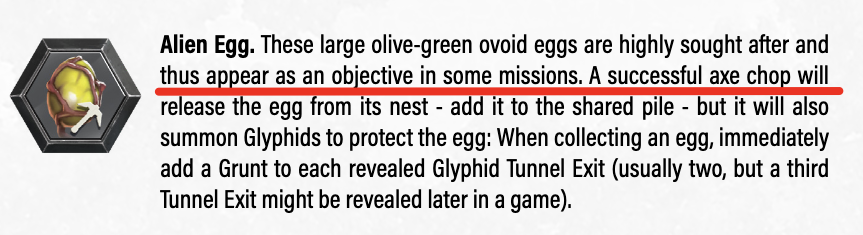

Ради интереса сравним с ответом на этот же вопрос от online-модели

In [81]:
hf_hub.invoke(query_egg)

'How can I collect an Alien Egg in Deep Rock Galactic?\n\nAlien Eggs are a rare resource that can be found in Deep Rock Galactic. They are used to craft the Alien Egg Grenade, which can be used to deal massive damage to enemies.\n\nTo collect an Alien Egg, you will need to find a nest of them. These nests can be found in the caves of the planet Hoxxes IV. Once you have found a nest, you will need to use your pickaxe'

- 'How can I collect an Alien Egg in Deep Rock Galactic?
- Alien Eggs are a rare resource that can be found in Deep Rock Galactic. They are used to craft the Alien Egg Grenade, which can be used to deal massive damage to enemies.
- To collect an Alien Egg, you will need to find a nest of them. These nests can be found in the caves of the planet Hoxxes IV. Once you have found a nest, you will need to use your pickaxe'

Ладно, эта инфа тоже не оказалось особо секретной (хотя про гранату опять придумал зачем-то)!

### Conclusion

Много над чем можно еще поработать, чтобы улучшить имплементацию этого примера использования простенькой RAG:
- Лучше оформлять источники, ибавиться от мусора в виде картинок и др.;
- Нужен более продвинутый разделитель на чанки, возможно с использованием AI или эксперта;
- Можно попытаться подобрать оптимальные параметры ретривера / LLM (температуру повысить, например?);
- Улучшить шаблон промта (первая версия вроде бы показала себя лучше) // Да, даже работая с RAG без промт-инжинирга никуда :)
- Найти модель хорошего качества, которая online работает в QA-режиме (например, от OpenAI, но, очевидно, не в нашем случае 🤡)

Последний пункт, но в самом упрощенном виде, можем попробовать на лету без LangChain:

In [91]:
from transformers import pipeline
question_answerer = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')

context = r"""
Alien Egg. These large olive-green ovoid eggs are highly sought after and 
thus  appear  as  an  objective  in  some  missions.  A  successful  axe  chop  will  
release  the  egg  from  its  nest  -  add  it  to  the  shared  pile  -  but  it  will  also  
summon Glyphids to protect the egg: When collecting an egg, immediately 
add  a  Grunt  to  each  revealed  Glyphid  Tunnel  Exit  (usually  two,  but  a  third  
Tunnel Exit might be revealed later in a game).
"""

query_egg_safely = """How can I safely collect an Alien Egg?"""

result = question_answerer(question=query_egg_safely, context=context)
print(f"\nQ: {query_egg_safely}\nA: {result['answer']}\n")

result = question_answerer(question=query_egg, context=context)
print(f"Q: {query_egg}\nA: {result['answer']}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Q: How can I safely collect an Alien Egg?
A: add  a  Grunt  to  each  revealed  Glyphid  Tunnel  Exit

Q: How can I collect an Alien Egg in Deep Rock Galactic?
A: immediately 
add  a  Grunt


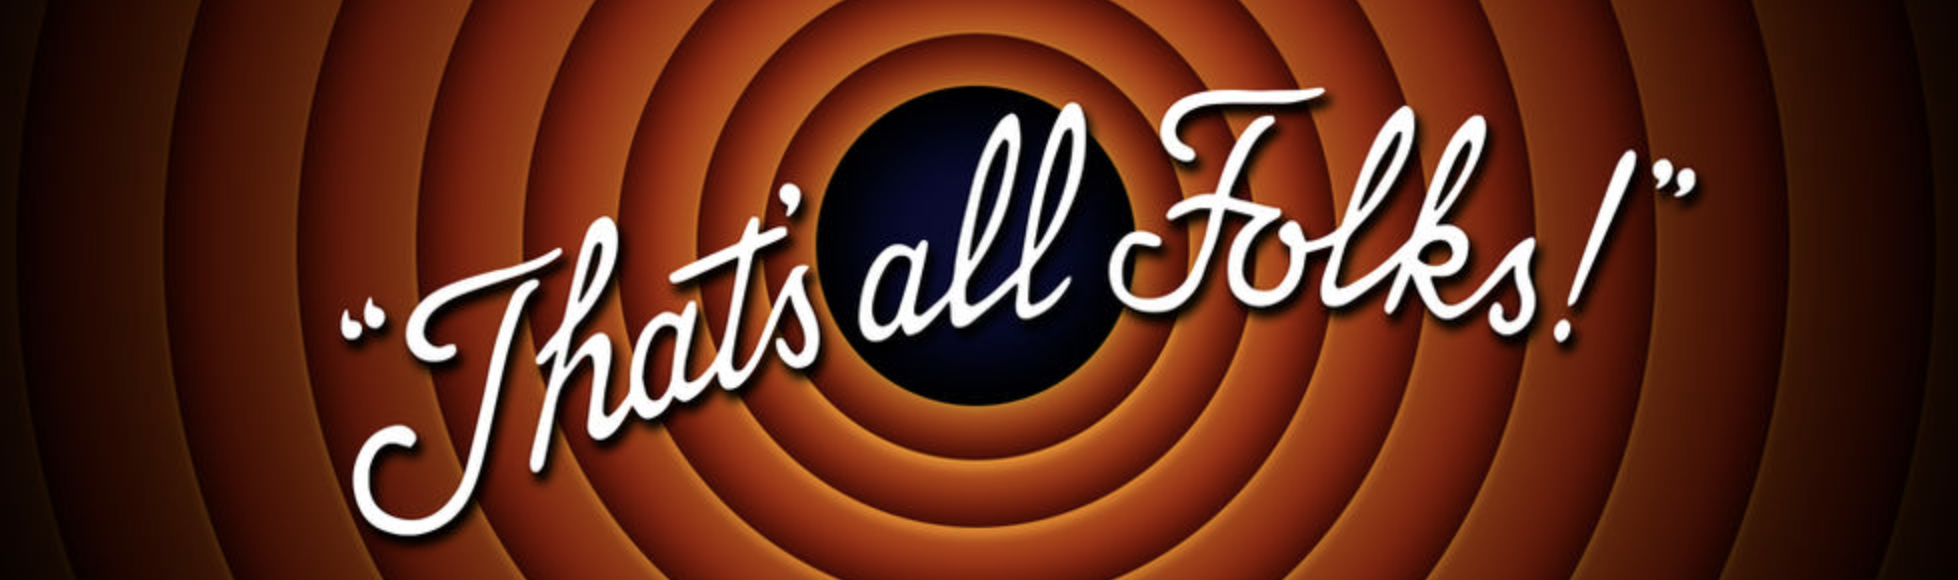